In [1]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

In [232]:
setwd('/media/ben/9c17f1c9-a45e-49ec-b547-8fbd2f25ccc6/GlyCompare/')

#### load libraries
source('example_notebook/functions.r')


clean<-function(x,skip=1,annot){
    x=cbind(annot,x)
    x$Secretor = ! x$Pateint.ID %in% c('L2','L3')
    x$scretor_col = ifelse(x$Secretor,'black','grey')
    x$DPP_col = heat.colors(length(unique(x$DPP)))[factor(x$DPP)]
    x$subject_col = rainbow(length(levels(x$Pateint.ID)))[x$Pateint.ID]
    x
}

##### load & prep data
annot = na.omit(read.csv('example_data/paper_hmo/source_data/annotation.csv'))
#head(annot)

tmp=t(data.matrix(read.csv('example_data/paper_hmo/intermediate_file/paper_hmo_motif_abd_table.csv',row.names=1,header =TRUE)))
colnames(tmp) = paste0('X',colnames(tmp))
rownames(tmp) = NULL
smandm = clean( tmp,annot=annot)

tmp<-read.csv('example_data/paper_hmo/source_data/abundance_table.csv')[-41,-1]
tmp$SUM=rowSums(tmp)
gly = clean ( tmp,annot=annot )

head(smandm)
head(gly)

vars = gsub('\\.','',c( grep('X',colnames(smandm),value=T), colnames(gly)[4:19] ))

gly_p = gly
gly_p[,colnames(gly)[4:19]] = gly[,colnames(gly)[4:19]]/as.numeric(as.character(gly$SUM))

data=list(#motif_abundance=ma,motif_abundance_dropped=mand,#motif_abundance_dropped_more=mandm,
    smallest_motif_abundance_dropped_more=smandm,glycan_concentration=gly,glycan_percent=gly_p)

data = lapply(data,function(x){
    colnames(x) = gsub('\\.','',colnames(x))
    x
})

keep_data=c('smallest_motif_abundance_dropped_more','glycan_percent')#,'glycan_percent')

#######################


Dataset,Pateint.ID,DPP,X1,X4,X8,X13,X15,X18,X32,⋯,X113,X120,X127,X141,X142,X143,Secretor,scretor_col,DPP_col,subject_col
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<chr>
1,L1,1,0.19166973,0.7856543,0.06204399,0.6677340,0.15944045,0.2499081,0.07891974,⋯,0.05178206,0.002598289,0.013227652,0.0013385124,0.005012860,0.0082147919,TRUE,black,#FF0000FF,#FF0000FF
1,L1,2,0.11718214,0.8259251,0.06456775,0.7357523,0.08697214,0.3489010,0.05561906,⋯,0.04275123,0.001698292,0.007511676,0.0048662595,0.007250400,0.0002612757,TRUE,black,#FF3300FF,#FF0000FF
1,L1,3,0.07822616,0.7939394,0.07757576,0.7167775,0.03228381,0.5018477,0.05194383,⋯,0.04795270,0.002690318,0.006001478,0.0007982262,0.004050259,0.0019512195,TRUE,black,#FF6600FF,#FF0000FF
1,L1,4,0.09139850,0.7912533,0.09345512,0.7062061,0.03405517,0.5156666,0.05873458,⋯,0.05676869,0.004445923,0.010555287,0.0011492862,0.006986451,0.0035688362,TRUE,black,#FF9900FF,#FF0000FF
1,L1,7,0.06754382,0.7672239,0.07069797,0.6536746,0.04064345,0.5264723,0.07326635,⋯,0.07141892,0.009958095,0.014689316,0.0036047402,0.012165998,0.0025233182,TRUE,black,#FFCC00FF,#FF0000FF
1,L1,14,0.08962425,0.7456007,0.10180919,0.6507500,0.03593629,0.5584970,0.05650224,⋯,0.05628576,0.006680068,0.013885882,0.0019174269,0.010731406,0.0031544766,TRUE,black,#FFFF00FF,#FF0000FF


Dataset,Pateint.ID,DPP,X2.FL,X3FL,LNnT,X3.SL,LNT,LNFP.I,LNFP.II,⋯,DSLNT,FLNH,DFLNH,FDSLNH,DSLNH,SUM,Secretor,scretor_col,DPP_col,subject_col
<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<dbl>,<lgl>,<chr>,<chr>,<chr>
1,L1,1,21765,1034,295,5781,882,3578,435,⋯,243,99,191,313,51,38102,TRUE,black,#FF0000FF,#FF0000FF
1,L1,2,17207,394,327,2335,1423,5269,431,⋯,179,52,222,8,149,30619,TRUE,black,#FF3300FF,#FF0000FF
1,L1,3,15841,135,748,874,3642,8313,506,⋯,191,91,137,66,27,33825,TRUE,black,#FF6600FF,#FF0000FF
1,L1,4,15213,65,735,736,3263,7990,444,⋯,352,147,231,118,38,33064,TRUE,black,#FF9900FF,#FF0000FF
1,L1,7,9739,41,381,729,3342,4547,504,⋯,93,221,270,56,80,22193,TRUE,black,#FFCC00FF,#FF0000FF
1,L1,14,13347,7,843,922,4587,7479,565,⋯,178,216,347,102,62,32335,TRUE,black,#FFFF00FF,#FF0000FF


### examine glycan and motif level clustering (Supp Fig6)

In [233]:

# col=rev(hcl.colors(20,palette = 'YlOrRd'))

# #pdf('~/Desktop/hmoclusters2.pdf',height=10,width=10)
# ## glycan abundance
# x=data$glycan_percent
# data_i = data.matrix(x[,colnames(x)%in%vars])
# rownames(data_i) = paste(x$PateintID,ifelse(x$Secretor,': Secretor',''))
# cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
# heatmap.2( data_i,RowSideColors=cols[,1],main='Glycan Relative Abundance (% nmol/mL)', scale='none',col=col,trace='none',
#     hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))
          
# ## motif abundance        
# x=data$smallest_motif_abundance_dropped_more
# data_i = data.matrix(x[,colnames(x)%in%vars])
# rownames(data_i) = paste(x$PateintID,ifelse(x$Secretor,': Secretor',''))
# cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
# heatmap.2( data_i,RowSideColors=cols[,1],main='Motif Relative Abundance', scale='none',col=col,trace='none',
#     hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))
# #dev.off()


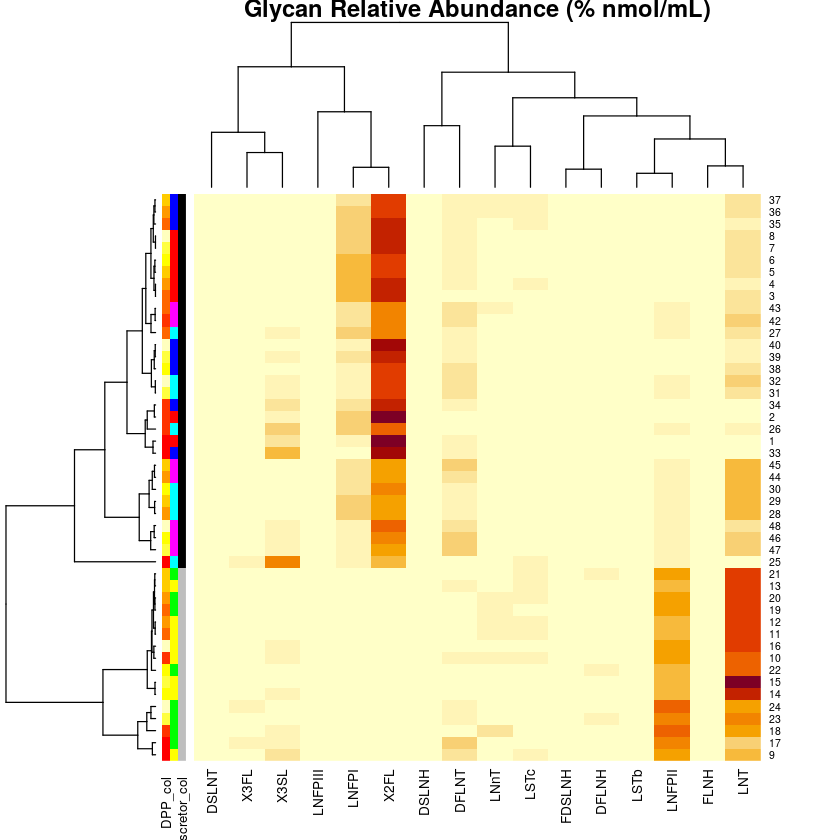

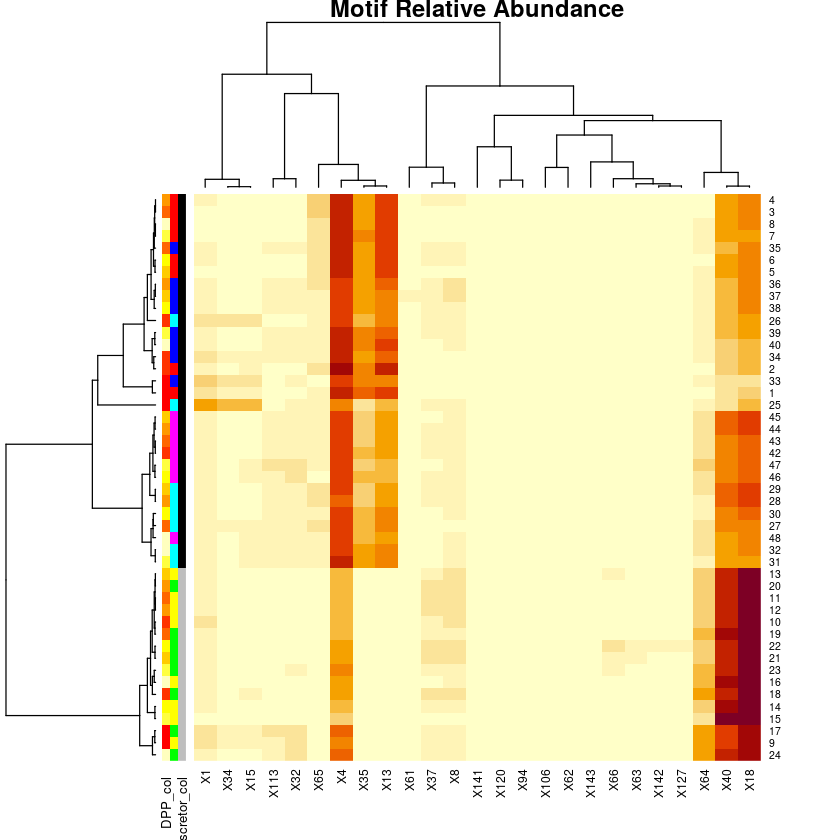

In [234]:

#pdf('~/Desktop/hmoclusters.pdf',height=10,width=10)
## glycan abundance
x=data$glycan_percent
data_i = data.matrix(x[,colnames(x)%in%vars])
cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
heatmap.plus( data_i,RowSideColors=cols,main='Glycan Relative Abundance (% nmol/mL)', scale='none',
    hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))
colorbar.plot( 2.5, 30, 1:15,col=hcl.colors(20,palette = 'Lajolla'))
          
## motif abundance        
x=data$smallest_motif_abundance_dropped_more
data_i = data.matrix(x[,colnames(x)%in%vars])
cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
heatmap.plus( data_i,RowSideColors=cols,main='Motif Relative Abundance', scale='none',
    hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))
#dev.off()

# Phenotype-Glycan & Phenotype-Motif Abundance Associations


## Predictability of every glycan and motif from Secretor status and DPP (Supp Fig8, Fig4b)
This analysis discovered several motifs signifiantly associated with secretor status and DPP, including X80

In [243]:
library(gee)

add_models=list()
inter_models=list()

i=0
out_i=lapply( data, function(x){
    i=i+1
    x$Secretor = as.numeric(x$Secretor)
    #	x$Secretor = relevel(factor(ifelse(x$Secretor,'secretor','nonsecretor')),ref='nonsecretor')
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
        try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods1=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
    mods1
})
out=do.call(rbind,out_i) #[-(4:5)])
out$data = unlist(lapply(strsplit(rownames(out),'\\.'),function(x) x[1]))


#############
out$response = factor( as.character(out$response), levels = sample(unique(as.character(out$response))))

library(geepack) 
              
# get whole models
out_models=lapply( data, function(x){
    i=i+1
    x$Secretor = as.numeric(x$Secretor)
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale(log(',motif,'+.0001))~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
#        try(mod<-geeglm(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
#        try(mod<-geeglm(as.formula(paste('Secretor~log(DPP)+scale(',motif,')')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NA)}else{mod}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    mods_i
})

Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.1828141  -0.2182130  -0.5486416 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.24101863  1.80677859  0.02604279 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.98549537 -1.29076805 -0.07083887 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.44228477  2.04224689  0.05031307 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4752061   0.2562899  -0.3402311 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8245452  -1.6920383   0.1539322 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-0.57591530  0.69109040  0.06342003 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4420620   0.3440417  -0.3532937 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.39050776  2.05978128  0.01686168 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.2246610  -1.0851528  -0.2687644 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.6707745  -1.6287499   0.2130945 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.2925686  -0.5095715  -0.5051161 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.7241488  -1.3896786   0.1016327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.76483595 -1.21738008  0.02012973 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8592455  -1.6508700   0.1212668 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.28592560  1.79642171  0.05336596 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.1841348  -1.2529841   0.3392029 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.3200892  -0.9423304   0.4972780 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.02967313 -0.40646264  0.12591051 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.8152413   0.7360193   0.1741596 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.07485932 -1.28521545  0.40813892 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.5534677  -1.2831805   0.1546744 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7462719  -0.2682980   0.4875651 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3735731  -1.3692474   0.2796570 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.7596119  -0.7102382  -0.1537615 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.13188664  1.90033261 -0.06417761 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.5773685  -0.2440027  -0.2199193 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.1719843   0.7565614  -0.3543550 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.1124361   1.2127270  -0.4818011 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.26446546 -0.44001429  0.01360227 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.9611486   1.9348229  -0.1663591 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.1937691  -1.2624051  -0.1907089 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.2146434   1.0913211  -0.2667799 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.2604303  -1.0010164  -0.3169612 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.5890449   0.7549786  -0.5740557 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.6728964   1.3855339  -0.1272557 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3560377   0.9768753  -0.5282954 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.1725223  -0.2896928   0.1920172 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.14153815  0.05876172 -0.09521524 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3828470   0.3622456  -0.3283628 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.9256052   0.6884985   0.2489960 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.39050776  2.05978128  0.01686168 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.9370949  -0.9345170  -0.1693694 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.53860322 -0.73200460 -0.02946389 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4420620   0.3440417  -0.3532937 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4145326  -1.4981615   0.3029300 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


  (Intercept)      Secretor      log(DPP) 
-1.2837764334  1.9445801043  0.0006237166 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.07432700 -1.83013112  0.07012224 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.2075064   0.4792369  -0.2765154 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)     Secretor     log(DPP) 
 1.208585248 -1.843299334  0.003806547 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.1986072  -0.3678712  -0.5048523 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.8152413   0.7360193   0.1741596 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8133020   0.1303065  -0.4748982 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.07485932 -1.28521545  0.40813892 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3735731  -1.3692474   0.2796570 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.7596119  -0.7102382  -0.1537615 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7462719  -0.2682980   0.4875651 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na

In [279]:


x=data$smallest_motif_abundance_dropped_more

mod<-geeglm(scale(log(X62+.0001))~ log(DPP)*Secretor,
    id=PateintID,data=x ,corstr='exchangeable')
parseSummary.GEEpack(mod)
summary(mod)

x=data$glycan_concentration

print('LSTb')
mod<-geeglm(scale(log(LSTb+.0001))~ log(DPP)*Secretor,
    id=PateintID,data=x ,corstr='exchangeable')
parseSummary.GEEpack(mod)
summary(mod)


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:12:57 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 1.59 & (1.48 - 1.7) & 0.00 \\ 
  log(DPP) & -0.37 & (-0.358 - -0.375) & 0.00 \\ 
  SecretorTRUE & -2.69 & (-1.89 - -3.48) & 0.00 \\ 
  log(DPP):SecretorTRUE & 0.70 & (0.604 - 0.803) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:12:57 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.63 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 43.00 \\ 
  6 & Shapiro-Wilks P & 0.53 \\ 
   \hline
\end{tabular}
\end{table}


Call:
geeglm(formula = scale(log(X62 + 1e-04)) ~ log(DPP) * Secretor, 
    data = x, id = PateintID, corstr = "exchangeable")

 Coefficients:
                      Estimate Std.err   Wald Pr(>|W|)    
(Intercept)             1.5893  0.0345 2126.7   <2e-16 ***
log(DPP)               -0.3665  0.0114 1033.5   <2e-16 ***
SecretorTRUE           -2.6856  0.1502  319.6   <2e-16 ***
log(DPP):SecretorTRUE   0.7032  0.0723   94.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Estimated Scale Parameters:
            Estimate Std.err
(Intercept)    0.362  0.0876

Correlation: Structure = exchangeable  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha     0.41   0.124
Number of clusters:   6   Maximum cluster size: 8 

[1] "LSTb"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:12:57 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 2.04 & (1.61 - 2.47) & 0.00 \\ 
  log(DPP) & -0.74 & (-0.662 - -0.814) & 0.00 \\ 
  SecretorTRUE & -2.15 & (-1.3 - -3) & 0.00 \\ 
  log(DPP):SecretorTRUE & 0.62 & (0.496 - 0.751) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:12:57 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.53 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 43.00 \\ 
  6 & Shapiro-Wilks P & 0.80 \\ 
   \hline
\end{tabular}
\end{table}


Call:
geeglm(formula = scale(log(LSTb + 1e-04)) ~ log(DPP) * Secretor, 
    data = x, id = PateintID, corstr = "exchangeable")

 Coefficients:
                      Estimate Std.err  Wald Pr(>|W|)    
(Intercept)             2.0411  0.1074 361.4  < 2e-16 ***
log(DPP)               -0.7380  0.0524 198.3  < 2e-16 ***
SecretorTRUE           -2.1504  0.2011 114.4  < 2e-16 ***
log(DPP):SecretorTRUE   0.6235  0.1047  35.5  2.6e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Estimated Scale Parameters:
            Estimate Std.err
(Intercept)    0.462   0.106

Correlation: Structure = exchangeable  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.315   0.174
Number of clusters:   6   Maximum cluster size: 8 

In [275]:
x=data$smallest_motif_abundance_dropped_more

mod<-geeglm(scale(log(X62+.0001))~ log(DPP),
    id=PateintID,data=x[ x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod)

x=data$smallest_motif_abundance_dropped_more
mod<-geeglm(scale(log(X62+.0001))~ log(DPP),
    id=PateintID,data=x[ !x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,5)



x=data$glycan_concentration

print('LSTb')
mod<-geeglm(scale(log(LSTb+.0001))~ log(DPP),
    id=PateintID,data=x[ x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod)

mod<-geeglm(scale(log(LSTb+.0001))~ log(DPP),
    id=PateintID,data=x[ !x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,5)

print('DSLNT')
mod<-geeglm(scale(log(DSLNT+.0001))~ log(DPP),
    id=PateintID,data=x[ x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod)

mod<-geeglm(scale(log(DSLNT+.0001))~ log(DPP),
    id=PateintID,data=x[ !x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,5)

print('DSLNH')
mod<-geeglm(scale(log(DSLNH+.0001))~ log(DPP),
    id=PateintID,data=x[ x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod)

mod<-geeglm(scale(log(DSLNH+.0001))~ log(DPP),
    id=PateintID,data=x[ !x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,5)

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & -0.74 & (-0.488 - -0.996) & 0.00 \\ 
  log(DPP) & 0.40 & (0.333 - 0.465) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 31.00 \\ 
  2 & Number of Clusters & 4.00 \\ 
  3 & Marginal R\verb|^|2 & 0.27 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 29.00 \\ 
  6 & Shapiro-Wilks P & 0.61 \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 1.22 & (1.0705 - 1.3654) & 0.00 \\ 
  log(DPP) & -0.66 & (-0.63058 - -0.6832) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 16.00 \\ 
  2 & Number of Clusters & 2.00 \\ 
  3 & Marginal R\verb|^|2 & 0.69 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 14.00 \\ 
  6 & Shapiro-Wilks P & 0.88 \\ 
   \hline
\end{tabular}
\end{table}

[1] "LSTb"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 0.32 & (0.177 - 0.452) & 0.16 \\ 
  log(DPP) & -0.15 & (-0.116 - -0.185) & 0.20 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 31.00 \\ 
  2 & Number of Clusters & 4.00 \\ 
  3 & Marginal R\verb|^|2 & 0.02 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 29.00 \\ 
  6 & Shapiro-Wilks P & 0.86 \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 1.29 & (1.0325 - 1.5424) & 0.00 \\ 
  log(DPP) & -0.69 & (-0.62726 - -0.76148) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 16.00 \\ 
  2 & Number of Clusters & 2.00 \\ 
  3 & Marginal R\verb|^|2 & 0.77 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 14.00 \\ 
  6 & Shapiro-Wilks P & 0.97 \\ 
   \hline
\end{tabular}
\end{table}

[1] "DSLNT"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 1.09 & (0.65 - 1.53) & 0.00 \\ 
  log(DPP) & -0.56 & (-0.36 - -0.771) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 31.00 \\ 
  2 & Number of Clusters & 4.00 \\ 
  3 & Marginal R\verb|^|2 & 0.46 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 29.00 \\ 
  6 & Shapiro-Wilks P & 0.05 \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 1.22 & (0.79033 - 1.6544) & 0.00 \\ 
  log(DPP) & -0.66 & (-0.63421 - -0.68431) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 16.00 \\ 
  2 & Number of Clusters & 2.00 \\ 
  3 & Marginal R\verb|^|2 & 0.69 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 14.00 \\ 
  6 & Shapiro-Wilks P & 0.58 \\ 
   \hline
\end{tabular}
\end{table}

[1] "DSLNH"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & -0.70 & (-0.176 - -1.23) & 0.07 \\ 
  log(DPP) & 0.38 & (0.249 - 0.509) & 0.03 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 31.00 \\ 
  2 & Number of Clusters & 4.00 \\ 
  3 & Marginal R\verb|^|2 & 0.24 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 29.00 \\ 
  6 & Shapiro-Wilks P & 0.92 \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & -0.03 & (-0.030456 - -0.038952) & 0.58 \\ 
  log(DPP) & 0.02 & (0.016379 - 0.021055) & 0.77 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 17:01:55 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 16.00 \\ 
  2 & Number of Clusters & 2.00 \\ 
  3 & Marginal R\verb|^|2 & 0.00 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 14.00 \\ 
  6 & Shapiro-Wilks P & 0.90 \\ 
   \hline
\end{tabular}
\end{table}

In [258]:
xtabs=lapply(out_models$smallest_motif_abundance_dropped_more,parseSummary.GEEpack,odsig=4)
#print(xtabs$X80)
print('x62')
(xtabs$X62)

xtabs2=lapply(out_models$glycan_percent,parseSummary.GEEpack,odsig=4)
#print(xtabs$X80)

print('lstb')
(xtabs2$LSTb)
print('dslnt')
(xtabs2$DSLNT)
print('DSLNH')
(xtabs2$DSLNH)

#### to see all motif and glycan models, uncomment the next line of code
#xtabs   # motifs
#xtabs2 #glycans

[1] "x62"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 13:42:14 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 0.74 & (0.3485 - 1.132) & 0.01 \\ 
  Secretor & -1.37 & (-0.6422 - -2.095) & 0.00 \\ 
  log(DPP) & 0.09 & (0.06535 - 0.1174) & 0.53 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 13:42:14 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.45 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P & 0.53 \\ 
   \hline
\end{tabular}
\end{table}

[1] "lstb"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 13:42:14 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 1.18 & (0.5933 - 1.766) & 0.00 \\ 
  Secretor & -1.81 & (-0.9251 - -2.695) & 0.00 \\ 
  log(DPP) & 0.01 & (0.009961 - 0.01298) & 0.86 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 13:42:14 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.76 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P & 0.02 \\ 
   \hline
\end{tabular}
\end{table}

[1] "dslnt"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 13:42:14 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 0.78 & (0.285 - 1.268) & 0.02 \\ 
  Secretor & 0.16 & (0.1216 - 0.2038) & 0.21 \\ 
  log(DPP) & -0.47 & (-0.3124 - -0.6257) & 0.01 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 13:42:14 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.34 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P & 0.22 \\ 
   \hline
\end{tabular}
\end{table}

[1] "DSLNH"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 13:42:14 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & -0.74 & (-0.5004 - -0.9808) & 0.00 \\ 
  Secretor & -0.23 & (-0.1115 - -0.3393) & 0.38 \\ 
  log(DPP) & 0.47 & (0.3884 - 0.5597) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 13:42:14 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.36 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P & 0.07 \\ 
   \hline
\end{tabular}
\end{table}

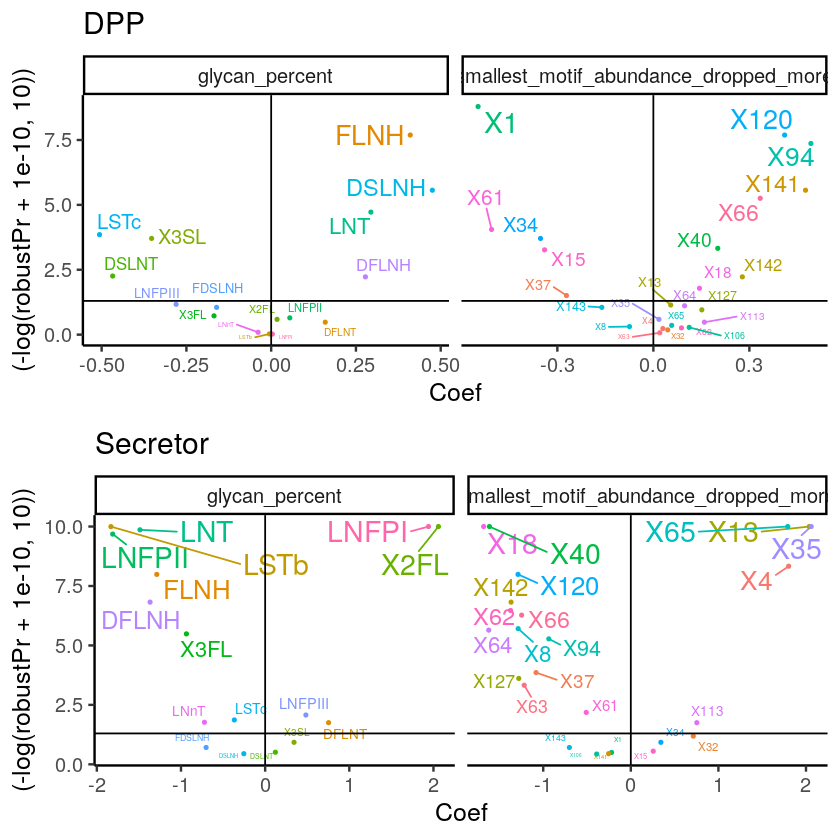

In [251]:
library(cowplot)


g1=ggplot( data=droplevels(out[out$type=='additive'& out$data%in%keep_data &out$vars=='DPP',]), # & !grepl('DPP',rownames(out)),]) ,
       aes(x=Coef,y=(-log(robustPr+1e-10,10)),size=(-log(robustPr+1e-10,10)),
        label=response,color=response,group=response))+
    geom_text_repel() + #scale_x_continuous(trans='log2') +
    facet_grid(~data,scale='free')+geom_point(size=.8)+#geom_path(size=.3)+
    geom_hline(yintercept=1.3)+geom_vline(xintercept=0)+
    theme_classic(base_size=15)+ggtitle('DPP')
g1Leg = get_legend(g1)
g1 <- g1+ guides(color=FALSE,size=FALSE)

g2<-ggplot( data=droplevels(out[out$type=='additive'& out$data%in%keep_data &out$vars=='Secretor',]), # & !grepl('DPP',rownames(out)),]) ,
       aes(x=Coef,y=(-log(robustPr+1e-10,10)),size=(-log(robustPr+1e-10,10)),
        label=response,color=response,group=response))+
    geom_text_repel() + #scale_x_continuous(trans='log2') +
    facet_grid(~data,scale='free')+geom_point(size=.8)+#geom_path(size=.3)+
    geom_hline(yintercept=1.3)+geom_vline(xintercept=0)+ 
    theme_classic(base_size=15)+ggtitle('Secretor')
g2Leg = get_legend(g2)
g2 <- g2+ guides(color=FALSE,size=FALSE)

g = grid.arrange(grobs=list(g1,g2),nrow=2)

ggsave(g,filename = '~/Desktop/suppfig8.pdf',height=10,width=10)
ggsave(g1Leg,filename = '~/Desktop/suppfig8.leg.pdf',height=15,width=15)


## Demonstration that X80 behaves distinctly from its related glycans (Fig4b)

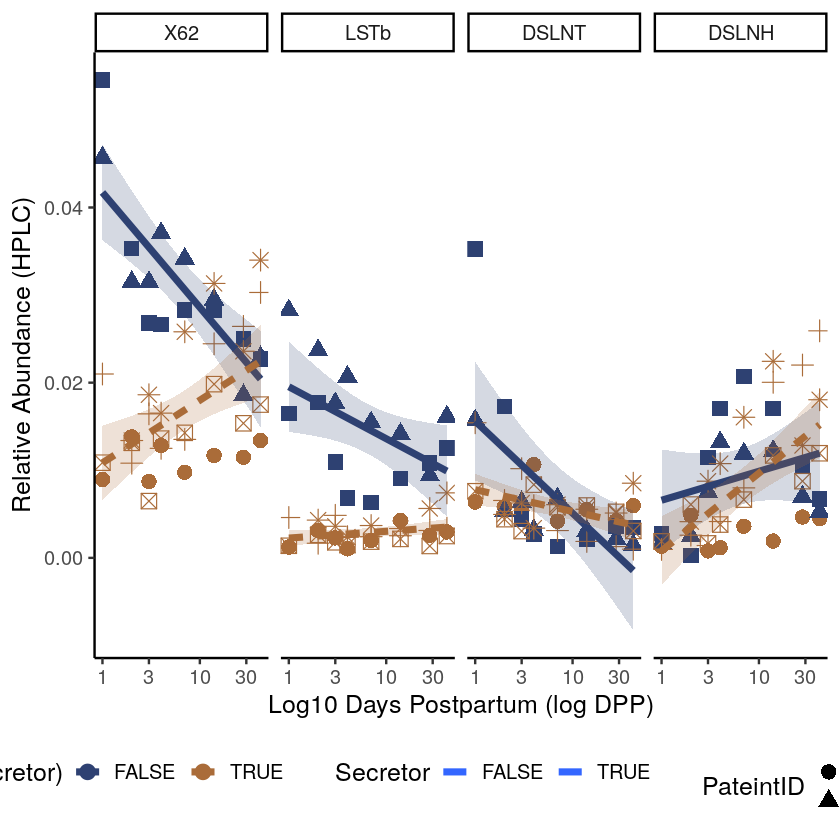

In [257]:
tmp= melt(cbind( data$smallest_motif_abundance_dropped_more[,c('DPP','X62','Secretor','PateintID')],data$glycan_percent[,c('DSLNT','DSLNH','LSTb')]) , id.vars=c('DPP','Secretor','PateintID'))

tmp$variable = factor(tmp$variable,levels=c('X62','LSTb','DSLNT','DSLNH'))
g<-ggplot(data=droplevels(tmp),aes(x=DPP,y=value,linetype=Secretor,color=factor(Secretor)))+
		geom_point(aes(shape=PateintID),size=4)+scale_x_log10()+
		xlab('Log10 Days Postpartum (log DPP)')+ylab('Relative Abundance (HPLC)')+
		stat_smooth(method='lm',size=2,alpha=.2,se=T,aes(fill=Secretor))+facet_grid(cols=vars(variable))+ 
        theme_classic(base_size = 15)+theme(legend.position="bottom")+
        scale_color_manual(values=c("#2E4172", "#AA6C39"))+scale_fill_manual(values=c("#2E4172", "#AA6C39"))+
        guides(linetype=F)
g
ggsave(g,filename = '~/Desktop/fig4b.pdf',height=6,width=15)

## Using the Product-Reactant ratio association to phenotype to determine important reactions in biosynthesis (Fig5 supporting exploration)

In [240]:
#### load heirachy
r = read.csv('example_data/paper_hmo/intermediate_file/edges.txt',header=FALSE)
heir = graph_from_edgelist( cbind( as.character(r[,1]) , as.character(r[,2]) ))
#plot(heir, layout=layout_as_tree(heir))

#### data
tmp = data$smallest_motif_abundance_dropped_more

comp=list()
comp_clean=list()
p = c(); lfc=c()
for( e in E(heir)){
    p = c(p,1);
    lfc=c(lfc,0);

    print(ends(heir,e))
    en=as.character(ends(heir,e))
    if(any(! paste0('X',en) %in% colnames(tmp) )){print(paste('skip',paste(en,collapse='_')));next}
    if( !all( apply(tmp[,paste0('X',en)],2,sd) > 1e-4 ) | all( tmp[[paste0('X',en[1])]] == tmp[[paste0('X',en[2])]] ) ){
        print(paste('skip',paste(en,collapse='_')));next}
    # run models
    f1 = Secretor ~ log(DPP)
    f2 = as.formula(paste0('Secretor ~ log(DPP) + I(',paste(paste0('X',rev(en)),collapse='/'),')'  ) )

    m1 = geeglm( f1, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m2 = geeglm( f2 , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')

    f0 = as.formula(paste0('Secretor ~ scale(X',en[1],')'))
    f = as.formula(paste0('Secretor ~  scale(X',en[1],') + scale(X',en[2],')'  ) )

    m0 = geeglm( f0, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m = geeglm( f , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')

    aov = anova(m0,m,test='LRT')

    out = data.frame( coef(summary(m2)) )
    out$iter = paste(en,collapse='_')
    out$vars = rownames(out)
    out$LRT = aov[[3]]

    #if(any(abs(out$Estimate)>15)){next}

    p[length(p)] = aov[[3]]
    lfc[length(lfc)] = coef(summary(m2))[3,1]

    comp[[paste(en,collapse='_')]] = list(m1,m2,aov,m)
    comp_clean[[paste(en,collapse='_')]] = out
}

out=do.call(rbind,comp_clean)
out = out[!grepl('Intercept|DPP',rownames(out)),]
#write.csv(out,file='motifAnyl/motif_heir.12.7.18.Bokan/stats.csv')


     [,1] [,2]
[1,] "5"  "18"
[1] "skip 5_18"
     [,1] [,2]
[1,] "5"  "32"
[1] "skip 5_32"
     [,1] [,2]
[1,] "5"  "34"
[1] "skip 5_34"
     [,1] [,2]
[1,] "5"  "35"
[1] "skip 5_35"
     [,1] [,2]
[1,] "18" "37"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "18" "40"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "37" "61"
     [,1] [,2]
[1,] "37" "63"
     [,1] [,2]
[1,] "40" "62"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "40" "64"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "40" "65"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "62" "106"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "64" "113"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "66" "94"
     [,1] [,2] 
[1,] "94" "120"
     [,1]  [,2] 
[1,] "127" "142"


In [241]:
out$q = p.adjust(out$LRT,'fdr')
#hist(out$q,main='FDR corrected significance of Likelihood Ratio Test\n(significantly secretion-associated reactions)')
sub<-out[out$q>0&out$q<.1,]
sub[order(sub$q),]
# E(heir)$p = p
# E(heir)$lfc = lfc
# E(heir)$q = p.adjust(p,'fdr')

# E(heir)$weight = (-log(E(heir)$q+.01,10)*10+.5)
# V(heir)$weight = strength(heir,mode='out')


# #pdf('motifAnyl/motif_heir.12.7.18.Bokan/significance_network.pdf',height=10,width=10)
# plot(heir,layout=layout_as_tree(heir),
#     edge.width=E(heir)$weight,edge.arrow.size=0,#edge.color=E(heir)$color,
#     vertex.size=5,vertex.label.cex=1,vertex.label.family='sans',
#     vertex.color=NA,vertex.frame.color=NA,main=)

(parseSummary.GEEpack(comp$'40_62'[[2]],6,logit=TRUE))
(parseSummary.GEEpack(comp$'62_106'[[2]],6,logit=TRUE))

,Estimate,Std.err,Wald,Pr...W..,iter,vars,LRT,q
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
94_120.I(X120/X94),0.01777115,0.01025369,3.003801,0.08306944,94_120,I(X120/X94),0.02481001,0.02706546
62_106.I(X106/X62),-0.05262085,0.02230748,5.564354,0.01832977,62_106,I(X106/X62),0.04866716,0.04866716


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 11:52:51 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 2.00 & (-1.39521 - 5.39784) & 0.42 \\ 
  log(DPP) & 1.00 & (0.999763 - 1.00003) & 0.14 \\ 
  I(X62/X40) & 0.99 & (0.957091 - 1.02266) & 0.55 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 11:52:51 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 1.00 \\ 
  4 & Marginal Entropy & 0.50 \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P &  \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 11:52:51 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 2.07 & (-1.48709 - 5.63095) & 0.41 \\ 
  log(DPP) & 1.00 & (0.998646 - 1.00133) & 0.99 \\ 
  I(X106/X62) & 0.95 & (0.907258 - 0.990221) & 0.02 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 11:52:51 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 1.00 \\ 
  4 & Marginal Entropy & 0.50 \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P &  \\ 
   \hline
\end{tabular}
\end{table}

## Exploration of specific reactions highlighted by anylizing the association of Product-Reactant ratio to Secretor status (Fig5)

In [551]:

# #g = grid.arrange(grobs=list(
#     ggplot(data[[1]],aes(x=DPP,y=X80/X38,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(PateintID)))+
#         geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=F,show.legend=F)+
#         theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
#         ggtitle("Percent of LNT converted to LSTb\n(X80/X38)")+xlab("Log10 Days Postpartum (log DPP)")+
#         scale_color_manual(values=c("#2E4172", "#AA6C39"))#,
#     ggplot(data[[1]],aes(x=DPP,y=X103/X80,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(PateintID)))+
#         geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=F,show.legend=F)+
#         theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
#         ggtitle("Percent of LSTb converted to DSLNT\n(X103/X80)")+xlab("Log10 Days Postpartum (log DPP)")+
#         scale_color_manual(values=c("#2E4172", "#AA6C39"))
# #),nrow=2)
# #ggsave(g,filename='motifAnyl/motif_heir.12.7.18.Bokan/ratio_trends.pdf',width=13,height=6)

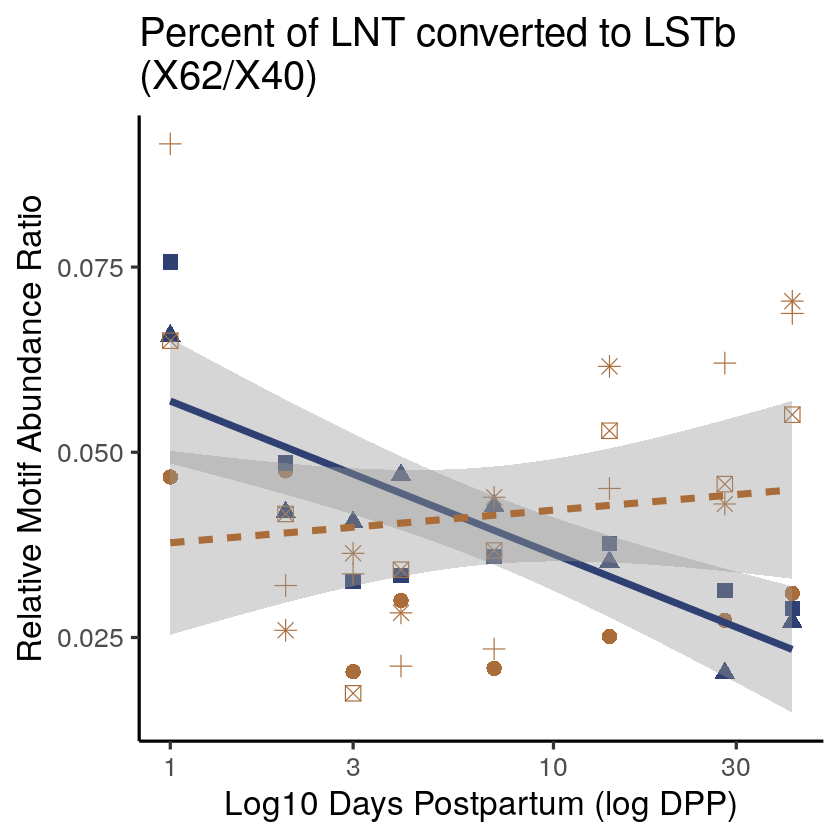

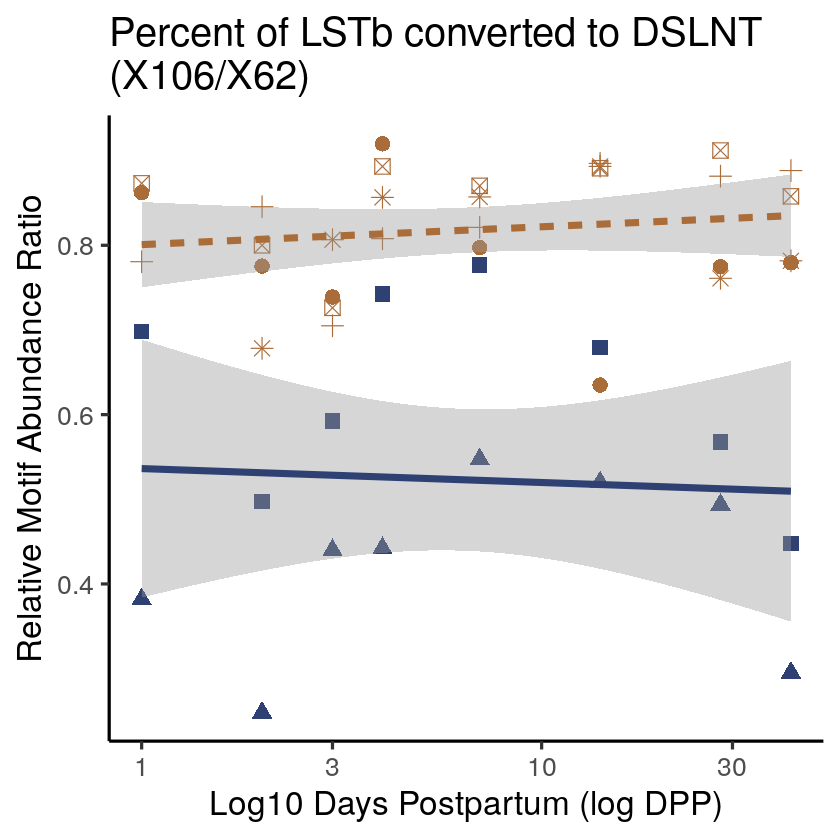

In [192]:

#g = grid.arrange(grobs=list(
    ggplot(data[[1]],aes(x=DPP,y=X62/X40,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(Secretor)))+
        geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=TRUE,show.legend=F)+
        theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
        ggtitle("Percent of LNT converted to LSTb\n(X62/X40)")+xlab("Log10 Days Postpartum (log DPP)")+
        scale_color_manual(values=c("#2E4172", "#AA6C39")) #,
    ggplot(data[[1]],aes(x=DPP,y=X106/X62,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(Secretor)))+
        geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=TRUE,show.legend=F)+
        theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
        ggtitle("Percent of LSTb converted to DSLNT\n(X106/X62)")+xlab("Log10 Days Postpartum (log DPP)")+
        scale_color_manual(values=c("#2E4172", "#AA6C39"))
#),nrow=2)
#ggsave(g,filename='~/Desktop/fig5.pdf',width=7,height=10)

# Power Analysis

In [193]:
library(gee)


i=0
out_i=lapply( data, function(x){
    i=i+1
    all_models=list()
    x$Secretor = as.numeric(x$Secretor)
    #	x$Secretor = relevel(factor(ifelse(x$Secretor,'secretor','nonsecretor')),ref='nonsecretor')
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
        try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    all_models = c(all_models,mods_i)
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods1=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
        try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ Secretor')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    all_models = c(all_models,mods_i)
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods2=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
        try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ PateintID')),id=Secretor,data=droplevels(x),corstr='exchangeable'))
        #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    all_models = c(all_models,mods_i)
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods3=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
    rbind(mods1,mods2,mods3)#,all_models)
})
#out_clean = lapply(out_i,function(x) x[[1]])
#out_models = lapply(out_i,function(x) x[[2]])
#names(out_mods)=names(data)
   
out=do.call(rbind,out_i) #[-(4:5)])
out$data = unlist(lapply(strsplit(rownames(out),'\\.'),function(x) x[1]))
                         
out$response = factor( as.character(out$response), levels = sample(unique(as.character(out$response))))



Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  1.0427171  -0.5506646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
-0.08103144  0.04279315 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 0.15679704 -0.08280538 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
-0.13112232  0.06924642 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.6397492  -0.3378550 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.2617765   0.1382456 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
-0.13222174  0.06982702 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.6629435  -0.3501041 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
-0.06808789  0.03595759 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.5279716  -0.2788247 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.3749148   0.1979946 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.9654138  -0.5098403 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
-0.16805211  0.08874924 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)     log(DPP) 
-0.016745874  0.008843588 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.2006453   0.1059619 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.1325877   0.0700203 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.6203054   0.3275867 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.9250838   0.4885418 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.2312838   0.1221423 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.3427026   0.1809831 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.7502741   0.3962239 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.2703593   0.1427782 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.9185244   0.4850778 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.5055105   0.2669629 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
   0.303625   -0.160346 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.1655712  -0.2510273 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  -1.192732    1.808336 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.8541522  -1.2950049 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  -1.348999    2.045256 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.1556204   0.2359406 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
   1.109953   -1.682832 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.4583275   0.6948836 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.2129840   0.3229112 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  -1.359244    2.060790 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.7263416  -1.1012276 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
   1.065875   -1.616005 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.3560268  -0.5397825 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.9125872  -1.3836000 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.8021587  -1.2161761 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
   1.084088   -1.643617 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  -1.186979    1.799614 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
   0.813055   -1.232696 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.6019199  -0.9125882 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.2631253  -0.3989319 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.4923300   0.7464358 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.8315945  -1.2608046 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.8402513  -1.2739294 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.1577284  -0.2391366 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.8920884  -1.3525211 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.4745208  -0.7194347 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.7255828   0.8798600   0.9024481   1.1061914   0.9757825   0.4554483 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
  0.9271677  -2.5160851  -1.7237152  -0.5905397  -0.1881312  -0.4898735 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -1.2188352   1.8843456   2.2616291   0.9729232   1.1631813   1.0040884 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
  0.8762115  -2.1470785  -2.3033418  -0.2848510  -0.1023948  -0.3543728 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.5568022   0.3886432   0.4137204   1.3036970   0.6919774   0.5407715 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.8664443   1.9875812   1.9652128   0.4489886  -0.1059338   0.9080129 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.5945660  -0.1573504   0.4298276   0.6805398   0.9288829   1.8413435 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.4028123   0.2782787   0.1013779   1.1274598   0.6078778   0.2874607 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)  PateintIDL2  PateintIDL3  PateintIDL4  PateintIDL5  PateintIDL6 
 0.776536751 -2.103316462 -2.168245681 -0.142698015 -0.008775902 -0.158991258 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.9615109   1.4218399   1.9538651   0.5099943   1.1275788   0.7263980 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.7395364   1.8466637   1.7641601   0.3605602  -0.3710681   0.8508122 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
-0.30632324  0.49430376  0.83039626 -0.05005399  0.63020140 -0.12022675 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -1.1434629   2.0754391   2.0366611   1.0108387   0.3533299   1.4189435 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.8199101   1.1892955   2.0548422   0.8547645   0.3460582   0.4251561 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
  -1.411613    2.323549    2.667852    1.036789    0.687195    1.803246 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
  1.0695188  -2.1283323  -2.3846635  -0.4726741  -0.6630618  -0.7253612 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -1.0671754   1.7432932   2.0171677   1.1786437   0.4368279   1.0213979 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.8584024   1.5647775   1.3558671   0.9132593   0.3152548   1.0216635 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.9692802   0.7843135   1.6804976   1.2344693   0.5806511   1.6166742 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
-0.25552791 -0.38813516 -0.08546895 -0.02194511  0.70700628  1.47402218 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.6279449   1.6588885   1.2601905   0.7709950  -0.1324225   0.1503144 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.9692996   1.3954475   2.2236544   0.9437392   0.4378406   0.7930897 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.8948628   0.9457568   1.1594255   0.9531014   0.7720915   1.6307925 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.9442313   1.5617031   2.1109364   0.9018857   0.3799470   0.6775851 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.7319832   0.4843821   1.9286259   0.6849396   0.4421538   0.8689144 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 0.08816407 -0.04655993 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.4207140  -0.2221814 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.6577115  -0.3473411 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.8910306  -0.4705581 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)     log(DPP) 
-0.018032321  0.009522968 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.2810455  -0.1484217 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.3832803  -0.2024124 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.4860061  -0.2566625 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.6177582  -0.3262415 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  1.0737560  -0.5670564 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.2166435  -0.1144106 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.9832108  -0.5192390 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.3585107   0.1893315 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 0.17926433 -0.09467047 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.6154158  -0.3250045 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.4835757   0.2553790 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  -1.250879    1.896494 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.1696136  -0.2571561 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.4850295   0.7353674 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.7808771   1.1839104 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.2896856  -0.4392007 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  -1.269597    1.924873 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.8401735  -1.2738114 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.7092833   1.0753650 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.6727487  -1.0199738 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.4753186   0.7206443 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.9088427   1.3779228 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.6234812   0.9452779 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.1834990  -0.2782082 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
-0.03500157  0.05306689 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.2259743   0.3426062 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.4639387   0.7033910 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 0.72106789 -2.18772155 -1.75617246 -0.12182981 -0.07709959 -0.10680052 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.1613289   0.1097078   0.5521772   0.3742190   0.2442414  -0.3800432 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
-0.20445574 -0.59830461  0.03715699  0.28320535  0.62373457  0.97758304 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 0.22033969 -1.18876567 -0.81366787  0.54369496  0.05057948  0.12990106 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.1712533   0.3006118   0.6212660   0.2478935  -0.9013700   0.8430992 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
  0.9906264  -2.3833435  -2.1371033  -0.3998024  -0.5472736  -0.4027509 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -1.0919779   1.5549273   2.3093754   1.3273238  -0.1059626   1.5196642 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 0.60612363 -1.41780867 -1.21300513  0.02833703 -0.52507056 -0.49534743 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.3849743   1.0721520   1.0432939   0.1762140  -0.7213998   0.7902442 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 0.36567184 -1.07861476 -0.60336609 -0.26920106  0.01959265 -0.24769465 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
  0.2840122  -1.5144280  -0.8712817  -0.1866030   0.1358245   0.8776190 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 0.58675295 -1.46550531 -0.95496295 -0.53349144 -0.40788058 -0.09752374 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.1511540   0.2511298   0.4181763   0.7296718  -0.6499755   0.1588885 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.3227732  -0.4188202   0.9943634   0.7907434  -0.1053438   0.7261139 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.2052101  -0.7832548   0.7417264   0.4998708   0.0802624   0.7622909 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.4188298  -0.3054215   0.2152037   0.7328469   0.4813830   1.5275577 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
-0.06808789  0.03595759 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.3371167  -0.1780332 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 0.06864195 -0.03625019 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.6629435  -0.3501041 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.5473163   0.2890408 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
-0.03531797  0.01865161 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
-0.10065297  0.05315539 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.5151858  -0.2720725 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 0.02515102 -0.01328239 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.9624267  -0.5082628 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.3427026   0.1809831 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
  0.8969613  -0.4736902 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.7502741   0.3962239 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.5055105   0.2669629 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
   0.303625   -0.160346 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
 -0.9185244   0.4850778 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  -1.359244    2.060790 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.6230651  -0.9446470 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.4839739  -0.7337668 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.2129840   0.3229112 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.9761987  -1.4800432 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  -1.282620    1.944617 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
   1.204341   -1.825937 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.3051841   0.4626985 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
   1.215643   -1.843072 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.2625544  -0.3980664 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
 -0.4923300   0.7464358 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
-0.06721248  0.10190279 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.8315945  -1.2608046 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.8920884  -1.3525211 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.4745208  -0.7194347 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
  0.1577284  -0.2391366 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)  PateintIDL2  PateintIDL3  PateintIDL4  PateintIDL5  PateintIDL6 
 0.776536751 -2.103316462 -2.168245681 -0.142698015 -0.008775902 -0.158991258 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.7294375   1.1404888   1.5645164   0.6594190   0.5500214   0.4239999 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -1.1218158   1.6018511   1.6097283   0.6833508   1.4459687   1.4283075 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.4028123   0.2782787   0.1013779   1.1274598   0.6078778   0.2874607 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.6856982   1.8061791   1.5176147   0.4008732  -0.3636595   0.7628220 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
  1.0326480  -2.2632826  -2.3672534  -0.4415416  -0.5037447  -0.5611255 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -1.2437932   2.3619042   2.5343652   1.1574295   0.1964987   1.2081000 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
  0.3697674  -0.5925046  -0.7573984   0.2256863  -0.3371627  -0.8125759 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.7800477   2.2941545   1.6972270   0.2609120  -0.1896240   0.5944123 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.1745719   0.4492943   0.4249583  -0.1582482   0.5659768  -0.2929961 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
-0.25552791 -0.38813516 -0.08546895 -0.02194511  0.70700628  1.47402218 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 0.22584093 -0.38804580 -0.19806102 -0.49086097 -0.18022356 -0.07957042 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.6279449   1.6588885   1.2601905   0.7709950  -0.1324225   0.1503144 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.9442313   1.5617031   2.1109364   0.9018857   0.3799470   0.6775851 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.7319832   0.4843821   1.9286259   0.6849396   0.4421538   0.8689144 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept) PateintIDL2 PateintIDL3 PateintIDL4 PateintIDL5 PateintIDL6 
 -0.8948628   0.9457568   1.1594255   0.9531014   0.7720915   1.6307925 


Warning message in gee(as.formula(paste("scale(log(", motif, "+.001))~ PateintID")), :
“Working correlation estimate not positive definite”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”

In [194]:
library(geepack) 
              
# get whole models
out_models=lapply( data, function(x){
    i=i+1
    x$Secretor = as.numeric(x$Secretor)
    mods_1 = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale(log(',motif,'+.0001))~ Secretor')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        if(is.na(mod)){return(NA)}else{mod}
    })
    names(mods_1) = paste(colnames(x)[colnames(x)%in%vars],'secretor',sep='_')
    
    mods_2 = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale(log(',motif,'+.0001))~ log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        if(is.na(mod)){return(NA)}else{mod}
    })
    names(mods_2) = paste(colnames(x)[colnames(x)%in%vars],'dpp',sep='_')
    
    mods_3 = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale(log(',motif,'+.0001))~ PateintID')),id=Secretor,data=droplevels(x),corstr='exchangeable'))
        if(is.na(mod)){return(NA)}else{mod}
    })
    names(mods_3) = paste(colnames(x)[colnames(x)%in%vars],'subject',sep='_')
    
    
    c(mods_1,mods_2,mods_3)
})

Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na

“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 

“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 

In [195]:
#### power analysis


### check normality
x=data$glycan_percent
p1=unlist(apply( x[colnames(x)[colnames(x)%in%vars]],2,function(y){
    out=NULL;
    try(out<-shapiro.test(scale(log(y+.001)))$p.value);
    out} ))
x=data$smallest_motif_abundance_dropped_more
p2=unlist(apply( x[colnames(x)[colnames(x)%in%vars]],2,function(y){
    out=NULL;
    try(out<-shapiro.test(scale(log(y+.001)))$p.value);
    out} ))

thresh=.1
pn = c(names(p1)[p.adjust(p1,'fdr')>thresh],names(p2)[p.adjust(p2,'fdr')>thresh])
print(pn)

x1=data$smallest_motif_abundance_dropped_more
x2=data$glycan_percent
vars1 = colnames(x1)[colnames(x1)%in%pn]
vars2 = colnames(x2)[colnames(x2)%in%pn]


#par(mfrow = c(1,3))

##### marginal r^2
keep1=grepl(paste(vars1,collapse='|'),names(out_models$smallest_motif_abundance_dropped_more))
keep2=grepl(paste(vars2,collapse='|'),names(out_models$glycan_percent))
mr2<-list(motifs=sapply(out_models$smallest_motif_abundance_dropped_more[keep1],function(mod){
        y = mod$y; y_bar=mean(y); y_hat=mod$fitted.values
        mr2=1-sum((y-y_hat)^2)/sum((y-y_bar)^2)
        mr2
    }),
    glycans=sapply(out_models$glycan_percent[keep2],function(mod){
        y = mod$y; y_bar=mean(y); y_hat=mod$fitted.values
        mr2=1-sum((y-y_hat)^2)/sum((y-y_bar)^2)
        mr2
    }))

### cohen's d

chnD<-list(
    motifs=sapply(vars1[vars1%in%pn],function(yn){
    y=x1[,yn]
    cohen.d(y,factor(x$Secretor), pooled=TRUE, paired=FALSE, na.rm=T, 
        hedges.correction = FALSE, conf.level = 0.95, noncentral = FALSE)$estimate
    }),
    glycans=sapply(vars2[vars2%in%pn],function(yn){
        y=x2[,yn]
        cohen.d(y,factor(x$Secretor), pooled=TRUE, paired=FALSE, na.rm=T, 
            hedges.correction = FALSE, conf.level = 0.95, noncentral = FALSE)$estimate
    }))



###### coeffiecients and noise

keep = out$type=='additive' & out$data%in%keep_data & 
    out$response%in%pn & #!grepl('DPP',rownames(out)) &
    out$robustPr<0.05


 [1] "X3FL"    "LNnT"    "LNFPIII" "LSTc"    "DSLNT"   "FLNH"    "DFLNH"  
 [8] "FDSLNH"  "DSLNH"   "X1"      "X8"      "X32"     "X62"     "X64"    
[15] "X66"     "X106"    "X120"    "X127"    "X141"    "X142"    "X143"   


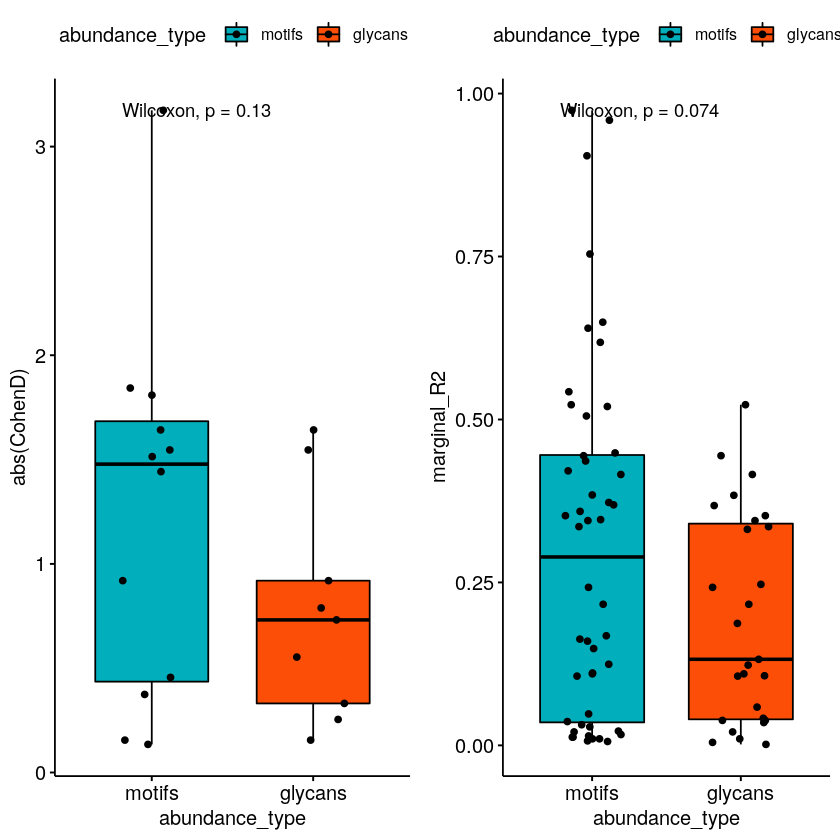

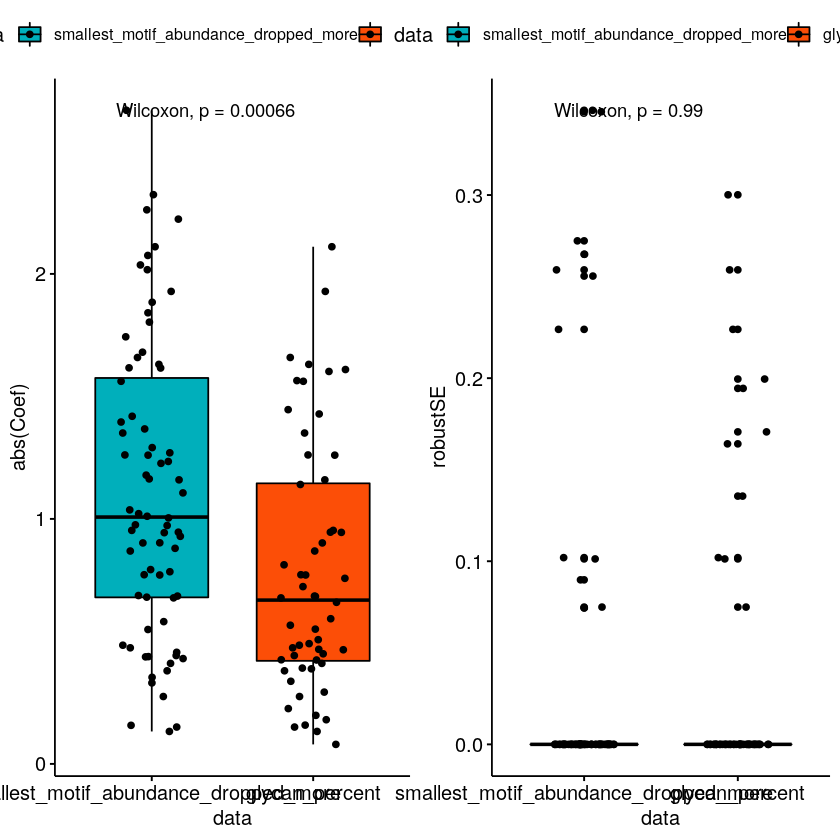

In [197]:
tmp=melt(chnD)
colnames(tmp)=c('CohenD','abundance_type')
p1=ggboxplot(tmp, x = "abundance_type", y = "abs(CohenD)",
                fill = "abundance_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

tmp=melt(mr2)
colnames(tmp)=c('marginal_R2','abundance_type')
p2=ggboxplot(tmp, x = "abundance_type", y = "marginal_R2",
                fill = "abundance_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

p3=ggboxplot(droplevels(out[keep,]),x='data',y='abs(Coef)',
                fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

p4=ggboxplot(droplevels(out[keep,]),x='data',y='robustSE',
                fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "greater"))


g1<-grid.arrange(grobs=list(p1,p2),nrow=1)
g2<-grid.arrange(grobs=list(p3,p4),nrow=1)
#g = grid.arrange(grobs=list(p1,p2,p3,p4),nrow=1)
ggsave(grid.arrange(grobs=list(p1,p2,p3,p4),nrow=2),filename = '~/Desktop/poweranyl.pdf',height=10,width=10)

In [489]:
#summary(aov(abs(Coef) ~ data , data=droplevels(out[keep,])))
#summary(aov(Coef ~ data , data=droplevels(out[keep,])))
#summary(aov(robustSE ~ data , data=droplevels(out[keep,])))

# dfmr2 = data.frame(mr2=c(mr2$motifs,mr2$glycans),
#                    type=c(rep('motifs',length(mr2$motifs)),rep('glycans',length(mr2$glycans))))

# #summary(aov(mr2~type, dfmr2))
# t.test(mr2$motifs,mr2$glycans)
# wilcox.test(mr2$motifs,mr2$glycans)

#t.test(abs(mr2$motifs),abs(mr2$glycans),alternative = 'greater')
#wilcox.test(abs(mr2$motifs),abs(mr2$glycans),alternative='greater')

#t.test(abs(chnD$motifs),abs(chnD$glycans),alternative = 'greater')
#wilcox.test(abs(chnD$motifs),abs(chnD$glycans),alternative='greater')

#t.test(abs(hG$motifs),abs(hG$glycans),alternative = 'greater')
#wilcox.test(abs(hG$motifs),abs(hG$glycans),alternative='greater')


## Using the likelihood ratio test to determine if more complex substructures are significantly more predictive of secretor status 

In [63]:
#### load heirachy
r = read.csv('motifAnyl/motif_heir.12.7.18.Bokan/edges.txt',header=F)
heir = graph_from_edgelist( cbind( as.character(r[,1]) , as.character(r[,2]) ))
#plot(heir, layout=layout_as_tree(heir))

#### data
tmp = data[[1]]

comp=list()
comp_clean=list()
for( e in E(heir)){
    print(ends(heir,e))
    en=as.character(ends(heir,e))
    if(any(! paste0('X',en) %in% colnames(tmp) )){print(paste('skip',paste(en,collapse='_')));next}
    if( !all( apply(tmp[,paste0('X',en)],2,sd) > 1e-4 ) | all( tmp[[paste0('X',en[1])]] == tmp[[paste0('X',en[2])]] ) ){
        print(paste('skip',paste(en,collapse='_')));
        next
    }
    # run models
    f1 = as.formula(paste('Secretor ~',paste0('X',en[1])))
    f2 = as.formula(paste('Secretor ~',paste(paste0('X',en),collapse='+')  ))
    m1 = geeglm( f1, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m2 = geeglm( f2 , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    aov = anova(m1,m2,test='LRT')
    out = data.frame( rbind(coef(summary(m1)) , coef(summary(m2))) )
    out$model = c(rep('m1',2),rep('m2',3))
    out$iter = paste(en,collapse='_')
    eni = c('Intercept',en)
    out$vars = c(eni[1:2],eni[1:3])
    out$LRT = aov[[3]]
    if(any(abs(out$Estimate)>15)){next}
    comp[[paste(en,collapse='_')]] = list(m1,m2,aov)
    comp_clean[[paste(en,collapse='_')]] = out
}
head(do.call(rbind,comp_clean))



     [,1] [,2]
[1,] "5"  "20"
[1] "skip 5_20"
     [,1] [,2]
[1,] "5"  "21"
[1] "skip 5_21"
     [,1] [,2]
[1,] "5"  "26"
[1] "skip 5_26"
     [,1] [,2]
[1,] "5"  "29"
[1] "skip 5_29"
     [,1] [,2]
[1,] "5"  "35"
[1] "skip 5_35"
     [,1] [,2]
[1,] "20" "37"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "38"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "40"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "41"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "43"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "51"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "53"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "26" "43"
     [,1] [,2]
[1,] "29" "45"
[1] "skip 29_45"
     [,1] [,2]
[1,] "29" "46"
     [,1] [,2]
[1,] "29" "51"
[1] "skip 29_51"
     [,1] [,2]
[1,] "37" "61"
[1] "skip 37_61"
     [,1] [,2]
[1,] "37" "64"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "61"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "65"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "79"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "80"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "85"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "86"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "40" "62"
     [,1] [,2]
[1,] "40" "63"
     [,1] [,2]
[1,] "40" "73"
     [,1] [,2]
[1,] "41" "62"
[1] "skip 41_62"
     [,1] [,2]
[1,] "41" "74"
     [,1] [,2]
[1,] "43" "64"
[1] "skip 43_64"
     [,1] [,2]
[1,] "43" "65"
[1] "skip 43_65"
     [,1] [,2]
[1,] "45" "66"
     [,1] [,2]
[1,] "45" "75"
[1] "skip 45_75"
     [,1] [,2]
[1,] "45" "88"
     [,1] [,2]
[1,] "46" "66"
[1] "skip 46_66"
     [,1] [,2]
[1,] "46" "76"
[1] "skip 46_76"
     [,1] [,2]
[1,] "51" "73"
     [,1] [,2]
[1,] "51" "74"
     [,1] [,2]
[1,] "51" "75"
[1] "skip 51_75"
     [,1] [,2]
[1,] "51" "76"
     [,1] [,2]
[1,] "51" "81"
     [,1] [,2]
[1,] "51" "85"
     [,1] [,2]
[1,] "53" "80"
[1] "skip 53_80"
     [,1] [,2]
[1,] "53" "81"
     [,1] [,2]
[1,] "61" "92"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "62" "97"
     [,1] [,2] 
[1,] "62" "113"
     [,1] [,2] 
[1,] "63" "113"
     [,1] [,2] 
[1,] "63" "116"
     [,1] [,2]
[1,] "64" "92"
[1] "skip 64_92"
     [,1] [,2]
[1,] "65" "92"
[1] "skip 65_92"
     [,1] [,2] 
[1,] "66" "102"
[1] "skip 66_102"
     [,1] [,2]
[1,] "73" "97"
[1] "skip 73_97"
     [,1] [,2]
[1,] "73" "98"
[1] "skip 73_98"
     [,1] [,2] 
[1,] "73" "100"
     [,1] [,2] 
[1,] "73" "116"
     [,1] [,2]
[1,] "74" "97"
[1] "skip 74_97"
     [,1] [,2]
[1,] "74" "99"
[1] "skip 74_99"
     [,1] [,2] 
[1,] "74" "101"
     [,1] [,2]
[1,] "75" "98"
     [,1] [,2]
[1,] "75" "99"
     [,1] [,2] 
[1,] "75" "102"
     [,1] [,2] 
[1,] "75" "104"
     [,1] [,2] 
[1,] "75" "110"
     [,1] [,2] 
[1,] "75" "117"
     [,1] [,2] 
[1,] "76" "100"
[1] "skip 76_100"
     [,1] [,2] 
[1,] "76" "101"
[1] "skip 76_101"
     [,1] [,2] 
[1,] "76" "102"
[1] "skip 76_102"
     [,1] [,2] 
[1,] "79" "103"
[1] "skip 79_103"
     [,1] [,2] 
[1,] "79" "108"
     [,1] [,2] 
[1,] "80" 

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "80" "109"
     [,1] [,2] 
[1,] "81" "104"
[1] "skip 81_104"
     [,1] [,2] 
[1,] "81" "109"
[1] "skip 81_109"
     [,1] [,2] 
[1,] "85" "108"
     [,1] [,2] 
[1,] "85" "109"
     [,1] [,2] 
[1,] "85" "110"
[1] "skip 85_110"
     [,1] [,2] 
[1,] "85" "112"
     [,1] [,2] 
[1,] "86" "112"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "88" "117"
[1] "skip 88_117"
     [,1] [,2] 
[1,] "97" "121"
[1] "skip 97_121"
     [,1] [,2] 
[1,] "97" "122"
     [,1] [,2] 
[1,] "97" "130"
     [,1] [,2] 
[1,] "98" "121"
[1] "skip 98_121"
     [,1] [,2] 
[1,] "98" "123"
     [,1] [,2] 
[1,] "98" "135"
     [,1] [,2] 
[1,] "98" "136"
     [,1] [,2] 
[1,] "99" "121"
[1] "skip 99_121"
     [,1] [,2] 
[1,] "99" "124"
     [,1] [,2] 
[1,] "99" "131"
     [,1]  [,2] 
[1,] "100" "122"
[1] "skip 100_122"
     [,1]  [,2] 
[1,] "100" "123"
[1] "skip 100_123"
     [,1]  [,2] 
[1,] "101" "122"
[1] "skip 101_122"
     [,1]  [,2] 
[1,] "101" "124"
[1] "skip 101_124"
     [,1]  [,2] 
[1,] "102" "123"
[1] "skip 102_123"
     [,1]  [,2] 
[1,] "102" "124"
[1] "skip 102_124"
     [,1]  [,2] 
[1,] "103" "126"
     [,1]  [,2] 
[1,] "104" "128"
[1] "skip 104_128"
     [,1]  [,2] 
[1,] "108" "126"
[1] "skip 108_126"
     [,1]  [,2] 
[1,] "108" "127"
[1] "skip 108_127"
     [,1]  [,2] 
[1,] "109" "126"
[1] "skip 109_126"
     [,1]  [

,Estimate,Std.err,Wald,Pr...W..,model,iter,vars,LRT
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
26_43.(Intercept),0.69494924,0.86693136,0.6425941,0.4227730,m1,26_43,Intercept,0.1158514
26_43.X26,-0.01889897,0.02903672,0.4236243,0.5151341,m1,26_43,26,0.1158514
26_43.(Intercept)1,0.69710437,0.86682828,0.6467396,0.4212808,m2,26_43,Intercept,0.1158514
26_43.X261,0.09174131,0.06288704,2.1281759,0.1446128,m2,26_43,26,0.1158514
26_43.X43,-0.16576369,0.10543322,2.4718600,0.1159007,m2,26_43,43,0.1158514
53_81.(Intercept),0.68414491,0.86525408,0.6251855,0.4291268,m1,53_81,Intercept,0.9929525


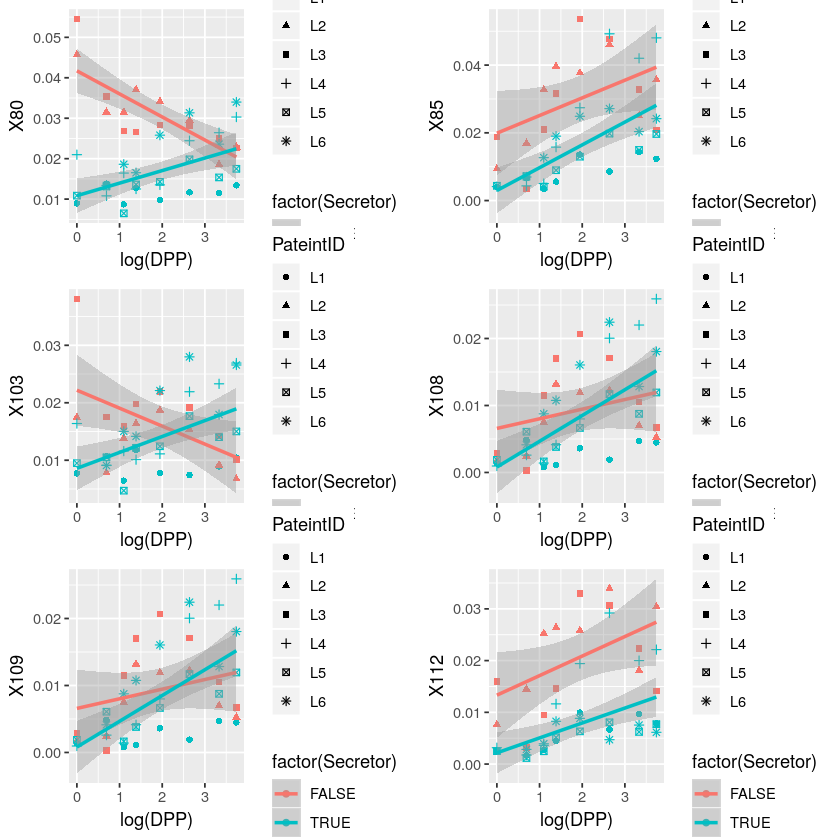

In [61]:
g=grid.arrange(grobs=list(
	ggplot(data[[1]],aes(x=log(DPP),y=X80,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X85,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X103,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X108,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X109,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X112,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm')
	))

In [73]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] geepack_1.2-1       gee_4.13-19         heatmap.plus_1.3   
 [4] lme4_1.1-21         openxlsx_4.1.0.1    reshape2_1.4.3     
 [7] metap_1.1           GGally_1.4.0        ggrepel_0.8.1      
[10] colorRamps_2.3      stringr_1.4.0       MASS_7.3-51.4 